# Investigating NaN Outputs

The Basic Capsnet model is supposed to act as a proof of concept audio capsule model, but training of these models has repeatedly resulted in the cost function returning nan after less than one epoch of training.

In [1]:
#  Import a bunch of stuff
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)

import importlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['image.cmap'] = 'hot'
import IPython.display as ipd
import tensorflow as tf
import mir_eval
from SegCaps import capsule_layers
from keras import layers

import audio_functions as af
import model_functions as mf
import audio_models
import dataset

Using TensorFlow backend.


In [7]:
importlib.reload(audio_models)

<module 'audio_models' from '/home/enterprise.internal.city.ac.uk/acvn728/MScFinalProject/audio_models.py'>

### Get the variables and data ready

In [2]:
#  Set variables
sample_rate=16384
n_fft=1024
fft_hop=256
patch_window=256
patch_hop=128
n_parallel_readers=4
normalise=True
batch_size = 5
shuffle=False
n_shuffle = 1
mag_phase = True
learning_rate = 0.002

#checkpoint = '52/52-10' #  Best U-net
checkpoint = 'nan_exp-1835'
model_base_dir = '/home/enterprise.internal.city.ac.uk/acvn728/checkpoints'

#directory_a = 'C:/Users/Toby/MSc_Project/Test_Audio/CHiME/test/Mixed'
#directory_b = 'C:/Users/Toby/MSc_Project/Test_Audio/CHiME/test/Voice'

#directory_a = 'C:/Users/Toby/Speech_Data/LibriSpeechMini/Mixed/train-clean-100/19/198/'
#directory_b = 'C:/Users/Toby/Speech_Data/LibriSpeechMini/Voice/train-clean-100/19/198/'

directory_a = '/home/enterprise.internal.city.ac.uk/acvn728/LibriSpeechMini/Mixed/train-clean-100/19/198/'
directory_b = '/home/enterprise.internal.city.ac.uk/acvn728/LibriSpeechMini/Voice/train-clean-100/19/198/'

#directory_a = '/data/Speech_Data/LibriSpeech/Mixed/test-clean/1580/141083/'
#directory_b = '/data/Speech_Data/LibriSpeech/Voice/test-clean/1580/141083/'


#  Create the pipeline
tf.reset_default_graph()
data = dataset.zip_files(directory_a, directory_b)
data = dataset.get_paired_dataset(data,
                                  sample_rate,
                                  n_fft,
                                  fft_hop,
                                  patch_window,
                                  patch_hop,
                                  n_parallel_readers,
                                  batch_size,
                                  n_shuffle,
                                  normalise,
                                  mag_phase)

#  Create the iterator
pipeline = data.make_initializable_iterator()
mixed_spec, voice_spec, mixed_audio, voice_audio = pipeline.get_next()

#  Create variable placeholders
is_training = tf.placeholder(shape=(), dtype=bool)
mixed_mag = tf.expand_dims(mixed_spec[:, :, :-1, 0], 3)
mixed_phase = tf.expand_dims(mixed_spec[:, :, :-1, 1], 3)
voice_mag = tf.expand_dims(voice_spec[:, :, :-1, 0], 3)

data

<PrefetchDataset shapes: ((?, 256, 513, 2), (?, 256, 513, 2), (?, 65280, 1), (?, 65280, 1)), types: (tf.float32, tf.float32, tf.float32, tf.float32)>

### Define the model structure

In [9]:
# Build U-Net model
print('Creating model')
model = audio_models.MagnitudeModel(mixed_mag, voice_mag, mixed_phase, mixed_audio, 
                                    voice_audio, 'basic_capsnet', is_training, learning_rate, name='U_Net_Model')
sess = tf.Session()
sess.run(tf.global_variables_initializer())

Creating model


### Load the saved weights - Skip this cell to hear results from a randomly initialised network

In [6]:

print('Loading checkpoint')
checkpoint_path = os.path.join(model_base_dir, checkpoint)
restorer = tf.train.Saver()
restorer.restore(sess, checkpoint_path)

Loading checkpoint
INFO:tensorflow:Restoring parameters from /home/enterprise.internal.city.ac.uk/acvn728/checkpoints/nan_exp-1835


### Run a batch

In [4]:
class MagnitudeModel(object):
    """
    Top level U-Net object.
    Attributes:
        mixed_mag: Input placeholder for magnitude spectrogram of mixed signals (voice plus background noise) - X
        voice_mag: Input placeholder for magnitude spectrogram of isolated voice signal - Y
        mixed_phase: Input placeholder for phase spectrogram of mixed signals (voice plus background noise)
        mixed_audio: Input placeholder for waveform audio of mixed signals (voice plus background noise)
        voice_audio: Input placeholder for waveform audio of isolated voice signal
        variant: The type of U-Net model (Normal convolutional or capsule based)
        is_training: Boolean - should the model be trained on the current input or not
        name: Model instance name
    """
    def __init__(self, mixed_mag, voice_mag, mixed_phase, mixed_audio, voice_audio, variant, is_training, learning_rate,
                 name):
        with tf.variable_scope(name):
            self.mixed_mag = mixed_mag
            self.voice_mag = voice_mag
            self.mixed_phase = mixed_phase
            self.mixed_audio = mixed_audio
            self.voice_audio = voice_audio
            self.variant = variant
            self.is_training = is_training

            if self.variant in ['unet', 'capsunet']:
                self.voice_mask_network = UNet(mixed_mag, variant, is_training=is_training, reuse=False, name='voice-mask-unet')
            elif self.variant == 'basic_capsnet':
                self.voice_mask_network = BasicCapsnet(mixed_mag, name='CapsNetBasic')

            self.voice_mask = self.voice_mask_network.output

            self.gen_voice = self.voice_mask * mixed_mag

            self.cost = mf.l1_loss(self.gen_voice, voice_mag)

            self.optimizer = tf.train.AdamOptimizer(
                learning_rate=learning_rate,
                beta1=0.5,
            )
            self.train_op = self.optimizer.minimize(self.cost)

class BasicCapsnet(object):

    def __init__(self, mixed_mag, name):
        """
        input_tensor: Tensor with shape [batch_size, height, width, channels]
        is_training:  Boolean - should the model be trained on the current input or not
        name:         Model instance name
        """
        with tf.variable_scope(name):
            self.mixed_mag = mixed_mag

            net = mf.conv(mixed_mag, filters=128, kernel_size=5, stride=(1, 1))

            # Reshape layer to be 1 capsule x [filters] atoms
            _, H, W, C = net.get_shape()
            net = layers.Reshape((H.value, W.value, 1, C.value))(net)
            self.conv1 = net
            
            net = capsule_layers.ConvCapsuleLayer(kernel_size=5, num_capsule=8, num_atoms=8, strides=1,
                                                  padding='same',
                                                  routings=1, name='primarycaps')(net)
            self.primary_caps = net

            net = capsule_layers.ConvCapsuleLayer(kernel_size=1, num_capsule=1, num_atoms=8, strides=1,
                                                  padding='same',
                                                  routings=3, name='seg_caps')(net)
            self.seg_caps = net
            
            net = capsule_layers.ConvCapsuleLayer(kernel_size=1, num_capsule=1, num_atoms=1, strides=1,
                                                  padding='same',
                                                  routings=3, name='reconstruction')(net)
            self.reco = net
            net = tf.squeeze(net, -1)

            self.output = net

In [5]:

model = MagnitudeModel(mixed_mag, voice_mag, mixed_phase, mixed_audio, 
                       voice_audio, 'basic_capsnet', is_training, learning_rate, name='U_Net_Model')
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [14]:
tf.trainable_variables()

[<tf.Variable 'U_Net_Model/CapsNetBasic/conv2d/kernel:0' shape=(5, 5, 1, 128) dtype=float32_ref>,
 <tf.Variable 'U_Net_Model/CapsNetBasic/conv2d/bias:0' shape=(128,) dtype=float32_ref>,
 <tf.Variable 'U_Net_Model/CapsNetBasic/primarycaps/W:0' shape=(5, 5, 128, 64) dtype=float32_ref>,
 <tf.Variable 'U_Net_Model/CapsNetBasic/primarycaps/b:0' shape=(1, 1, 8, 8) dtype=float32_ref>,
 <tf.Variable 'U_Net_Model/CapsNetBasic/seg_caps/W:0' shape=(1, 1, 8, 8) dtype=float32_ref>,
 <tf.Variable 'U_Net_Model/CapsNetBasic/seg_caps/b:0' shape=(1, 1, 1, 8) dtype=float32_ref>,
 <tf.Variable 'U_Net_Model/CapsNetBasic/reconstruction/W:0' shape=(1, 1, 8, 1) dtype=float32_ref>,
 <tf.Variable 'U_Net_Model/CapsNetBasic/reconstruction/b:0' shape=(1, 1, 1, 1) dtype=float32_ref>]

In [37]:
saver = tf.train.Saver(tf.global_variables(), max_to_keep=2, write_version=tf.train.SaverDef.V2)
model_folder = 'nan_exp'
cost = 0
#i = 0
sess.run(pipeline.initializer)
weights = []
biases = []
while i < 10000 and not np.isnan(cost):
    try:
        _, cost, m_mag, v_mag, v_mask, m_phase, v_mag, v_est_mag, v_wave, m_wave, \
        conv_w, conv_b, conv_out, prim_w, prim_b, prim_out, seg_w, seg_b, seg_out, \
        reco_w, reco_b, reco_out = sess.run([model.train_op, model.cost, model.mixed_mag, model.voice_mag, model.voice_mask,
                                             model.mixed_phase, model.voice_mag, model.gen_voice, model.voice_audio, 
                                             model.mixed_audio,
                                             'U_Net_Model/CapsNetBasic/conv2d/kernel:0',
                                             'U_Net_Model/CapsNetBasic/conv2d/bias:0',
                                             model.voice_mask_network.conv1,
                                             'U_Net_Model/CapsNetBasic/primarycaps/W:0',
                                             'U_Net_Model/CapsNetBasic/primarycaps/b:0',
                                             model.voice_mask_network.primary_caps,
                                             'U_Net_Model/CapsNetBasic/seg_caps/W:0',
                                             'U_Net_Model/CapsNetBasic/seg_caps/b:0',
                                             model.voice_mask_network.seg_caps,
                                             'U_Net_Model/CapsNetBasic/reconstruction/W:0',
                                             'U_Net_Model/CapsNetBasic/reconstruction/b:0',
                                             model.voice_mask_network.reco])
        print('Iteration {i}: cost = {c}'.format(i=i, c=cost))
        #print('\t', conv_w.mean(), prim_w.mean(), seg_w.mean(), reco_w.mean(),'\n\t',
        #      conv_b.mean(), prim_b.mean(), seg_b.mean(), reco_b.mean())
        weights.extend([conv_w.mean(), prim_w.mean(), seg_w.mean(), reco_w.mean()])
        biases.extend([conv_b.mean(), prim_b.mean(), seg_b.mean(), reco_b.mean()])
        i += 1
    except tf.errors.OutOfRangeError:
        print('Epoch complete')
        saver.save(sess, os.path.join(model_base_dir, model_folder), global_step=i)
        sess.run(pipeline.initializer)
print(conv_w.mean(), prim_w.mean(), seg_w.mean(), reco_w.mean())
print(conv_b.mean(), prim_b.mean(), seg_b.mean(), reco_b.mean())

Iteration 1: cost = 0.002000723499804735
Iteration 2: cost = 0.0035876347683370113
Iteration 3: cost = 0.003802469465881586
Iteration 4: cost = 0.0035623773001134396
Iteration 5: cost = 0.002821429632604122
Epoch complete
Iteration 6: cost = 0.002223770134150982
Iteration 7: cost = 0.003525306936353445
Iteration 8: cost = 0.003557395190000534
Iteration 9: cost = 0.0033283736556768417
Iteration 10: cost = 0.0027253564912825823
Epoch complete
Iteration 11: cost = 0.002244922798126936
Iteration 12: cost = 0.0034813079982995987
Iteration 13: cost = 0.0034819343127310276
Iteration 14: cost = 0.0032636672258377075
Iteration 15: cost = 0.0027013595681637526
Epoch complete
Iteration 16: cost = 0.002245774958282709
Iteration 17: cost = 0.003457435639575124
Iteration 18: cost = 0.003453044919297099
Iteration 19: cost = 0.0032321636099368334
Iteration 20: cost = 0.002702148864045739
Epoch complete
Iteration 21: cost = 0.0022585485130548477
Iteration 22: cost = 0.003458787454292178
Iteration 23: c

Iteration 180: cost = 0.0026895105838775635
Epoch complete
Iteration 181: cost = 0.0023223727475851774
Iteration 182: cost = 0.003438283922150731
Iteration 183: cost = 0.0034339609555900097
Iteration 184: cost = 0.0031629116274416447
Iteration 185: cost = 0.002690732479095459
Epoch complete
Iteration 186: cost = 0.002316608326509595
Iteration 187: cost = 0.003437693463638425
Iteration 188: cost = 0.003396758809685707
Iteration 189: cost = 0.0031757578253746033
Iteration 190: cost = 0.0026827803812921047
Epoch complete
Iteration 191: cost = 0.0023153461515903473
Iteration 192: cost = 0.0034300866536796093
Iteration 193: cost = 0.003421895205974579
Iteration 194: cost = 0.0031529683619737625
Iteration 195: cost = 0.0026884344406425953
Epoch complete
Iteration 196: cost = 0.002311832271516323
Iteration 197: cost = 0.003434967715293169
Iteration 198: cost = 0.003402110654860735
Iteration 199: cost = 0.003176466329023242
Iteration 200: cost = 0.002682596445083618
Epoch complete
Iteration 20

Iteration 357: cost = 0.003407306969165802
Iteration 358: cost = 0.0034038883168250322
Iteration 359: cost = 0.003149325493723154
Iteration 360: cost = 0.002672902075573802
Epoch complete
Iteration 361: cost = 0.0022995788604021072
Iteration 362: cost = 0.0034161321818828583
Iteration 363: cost = 0.003426778595894575
Iteration 364: cost = 0.00314684328623116
Iteration 365: cost = 0.0026788259856402874
Epoch complete
Iteration 366: cost = 0.0022961748763918877
Iteration 367: cost = 0.00341130536980927
Iteration 368: cost = 0.003401219379156828
Iteration 369: cost = 0.0031532763969153166
Iteration 370: cost = 0.00267290067858994
Epoch complete
Iteration 371: cost = 0.002303223591297865
Iteration 372: cost = 0.0034120455384254456
Iteration 373: cost = 0.003421339439228177
Iteration 374: cost = 0.0031451594550162554
Iteration 375: cost = 0.00267521059140563
Epoch complete
Iteration 376: cost = 0.0022945308592170477
Iteration 377: cost = 0.0034134485758841038
Iteration 378: cost = 0.0033884

Iteration 534: cost = 0.003129876684397459
Iteration 535: cost = 0.0026643122546374798
Epoch complete
Iteration 536: cost = 0.0022756573744118214
Iteration 537: cost = 0.003389393910765648
Iteration 538: cost = 0.003378578694537282
Iteration 539: cost = 0.003141865599900484
Iteration 540: cost = 0.0026568719185888767
Epoch complete
Iteration 541: cost = 0.0022836129646748304
Iteration 542: cost = 0.003394629806280136
Iteration 543: cost = 0.0034033232368528843
Iteration 544: cost = 0.0031286892481148243
Iteration 545: cost = 0.0026633944362401962
Epoch complete
Iteration 546: cost = 0.0022740866988897324
Iteration 547: cost = 0.0033869966864585876
Iteration 548: cost = 0.0033855214715003967
Iteration 549: cost = 0.003141937777400017
Iteration 550: cost = 0.0026574640069156885
Epoch complete
Iteration 551: cost = 0.0022836639545857906
Iteration 552: cost = 0.0033931047655642033
Iteration 553: cost = 0.003408462507650256
Iteration 554: cost = 0.003128721844404936
Iteration 555: cost = 0.

Iteration 711: cost = 0.0022739837877452374
Iteration 712: cost = 0.0033786736894398928
Iteration 713: cost = 0.0034059665631502867
Iteration 714: cost = 0.003120374632999301
Iteration 715: cost = 0.002657060045748949
Epoch complete
Iteration 716: cost = 0.002262260764837265
Iteration 717: cost = 0.0033698580227792263
Iteration 718: cost = 0.003386354073882103
Iteration 719: cost = 0.0031238426454365253
Iteration 720: cost = 0.002648794325068593
Epoch complete
Iteration 721: cost = 0.002276769606396556
Iteration 722: cost = 0.0033868118189275265
Iteration 723: cost = 0.0034058343153446913
Iteration 724: cost = 0.0031214626505970955
Iteration 725: cost = 0.0026592472568154335
Epoch complete
Iteration 726: cost = 0.0022638123482465744
Iteration 727: cost = 0.0033679890912026167
Iteration 728: cost = 0.0033829149324446917
Iteration 729: cost = 0.0031213369220495224
Iteration 730: cost = 0.002648143097758293
Epoch complete
Iteration 731: cost = 0.0022756168618798256
Iteration 732: cost = 0

Iteration 887: cost = 0.0033602931071072817
Iteration 888: cost = 0.0033669874537736177
Iteration 889: cost = 0.0031161331571638584
Iteration 890: cost = 0.0026285669300705194
Epoch complete
Iteration 891: cost = 0.002258762251585722
Iteration 892: cost = 0.003380297217518091
Iteration 893: cost = 0.0034057791344821453
Iteration 894: cost = 0.003116845851764083
Iteration 895: cost = 0.002645662520080805
Epoch complete
Iteration 896: cost = 0.002243648748844862
Iteration 897: cost = 0.0033660263288766146
Iteration 898: cost = 0.0033812467008829117
Iteration 899: cost = 0.0031174218747764826
Iteration 900: cost = 0.002633140655234456
Epoch complete
Iteration 901: cost = 0.002257654210552573
Iteration 902: cost = 0.00337858940474689
Iteration 903: cost = 0.003417855128645897
Iteration 904: cost = 0.003120486158877611
Iteration 905: cost = 0.002649820176884532
Epoch complete
Iteration 906: cost = 0.002248761709779501
Iteration 907: cost = 0.0033686987590044737
Iteration 908: cost = 0.00337

Iteration 1062: cost = 0.0033446517772972584
Iteration 1063: cost = 0.0033789421431720257
Iteration 1064: cost = 0.0031100152991712093
Iteration 1065: cost = 0.002628824906423688
Epoch complete
Iteration 1066: cost = 0.0022490466944873333
Iteration 1067: cost = 0.0033563903998583555
Iteration 1068: cost = 0.003399065462872386
Iteration 1069: cost = 0.0031126553658396006
Iteration 1070: cost = 0.0026386254467070103
Epoch complete
Iteration 1071: cost = 0.0022400261368602514
Iteration 1072: cost = 0.0033432398922741413
Iteration 1073: cost = 0.003368501318618655
Iteration 1074: cost = 0.0031108404509723186
Iteration 1075: cost = 0.002630500588566065
Epoch complete
Iteration 1076: cost = 0.0022494029253721237
Iteration 1077: cost = 0.0033543617464601994
Iteration 1078: cost = 0.0033711313735693693
Iteration 1079: cost = 0.003106899093836546
Iteration 1080: cost = 0.002633728552609682
Epoch complete
Iteration 1081: cost = 0.0022361711598932743
Iteration 1082: cost = 0.0033439204562455416
I

Iteration 1235: cost = 0.0026188502088189125
Epoch complete
Iteration 1236: cost = 0.0022329967468976974
Iteration 1237: cost = 0.0033177391160279512
Iteration 1238: cost = 0.0033570281229913235
Iteration 1239: cost = 0.0031004087068140507
Iteration 1240: cost = 0.002613564720377326
Epoch complete
Iteration 1241: cost = 0.0022405933123081923
Iteration 1242: cost = 0.0033361390233039856
Iteration 1243: cost = 0.00335804745554924
Iteration 1244: cost = 0.0030947320628911257
Iteration 1245: cost = 0.002617325633764267
Epoch complete
Iteration 1246: cost = 0.00223210034891963
Iteration 1247: cost = 0.0033161859028041363
Iteration 1248: cost = 0.003352376166731119
Iteration 1249: cost = 0.003099811729043722
Iteration 1250: cost = 0.0026120650582015514
Epoch complete
Iteration 1251: cost = 0.0022384754847735167
Iteration 1252: cost = 0.003334205597639084
Iteration 1253: cost = 0.0033498879056423903
Iteration 1254: cost = 0.0030927988700568676
Iteration 1255: cost = 0.0026147651951760054
Epoc

Iteration 1408: cost = 0.003332101507112384
Iteration 1409: cost = 0.003094148589298129
Iteration 1410: cost = 0.002607868518680334
Epoch complete
Iteration 1411: cost = 0.0022323017474263906
Iteration 1412: cost = 0.003330536186695099
Iteration 1413: cost = 0.0033418729435652494
Iteration 1414: cost = 0.0030914475210011005
Iteration 1415: cost = 0.002613858552649617
Epoch complete
Iteration 1416: cost = 0.002219950780272484
Iteration 1417: cost = 0.003322866279631853
Iteration 1418: cost = 0.003330568317323923
Iteration 1419: cost = 0.003093868028372526
Iteration 1420: cost = 0.002607279224321246
Epoch complete
Iteration 1421: cost = 0.0022319206036627293
Iteration 1422: cost = 0.0033284109085798264
Iteration 1423: cost = 0.0033405483700335026
Iteration 1424: cost = 0.0030911818612366915
Iteration 1425: cost = 0.002612394280731678
Epoch complete
Iteration 1426: cost = 0.0022199712693691254
Iteration 1427: cost = 0.003318303031846881
Iteration 1428: cost = 0.0033293336164206266
Iterati

Iteration 1581: cost = 0.002218774054199457
Iteration 1582: cost = 0.0033138468861579895
Iteration 1583: cost = 0.003318683011457324
Iteration 1584: cost = 0.0030842763371765614
Iteration 1585: cost = 0.002600163919851184
Epoch complete
Iteration 1586: cost = 0.002217428758740425
Iteration 1587: cost = 0.0033102042507380247
Iteration 1588: cost = 0.0033232062123715878
Iteration 1589: cost = 0.0030854567885398865
Iteration 1590: cost = 0.0026007075794041157
Epoch complete
Iteration 1591: cost = 0.002219095127657056
Iteration 1592: cost = 0.0033138450235128403
Iteration 1593: cost = 0.0033226124942302704
Iteration 1594: cost = 0.0030847962480038404
Iteration 1595: cost = 0.0026006153784692287
Epoch complete
Iteration 1596: cost = 0.0022153696045279503
Iteration 1597: cost = 0.003309270367026329
Iteration 1598: cost = 0.003334683133289218
Iteration 1599: cost = 0.003084228141233325
Iteration 1600: cost = 0.002602652180939913
Epoch complete
Iteration 1601: cost = 0.0022201419342309237
Iter

Iteration 1754: cost = 0.003082091687247157
Iteration 1755: cost = 0.002600995358079672
Epoch complete
Iteration 1756: cost = 0.002221242059022188
Iteration 1757: cost = 0.003305270103737712
Iteration 1758: cost = 0.003361764596775174
Iteration 1759: cost = 0.003085512202233076
Iteration 1760: cost = 0.002599851693958044
Epoch complete
Iteration 1761: cost = 0.002221787581220269
Iteration 1762: cost = 0.0032990730833262205
Iteration 1763: cost = 0.0033712596632540226
Iteration 1764: cost = 0.0030822674743831158
Iteration 1765: cost = 0.0026042857207357883
Epoch complete
Iteration 1766: cost = 0.002220572903752327
Iteration 1767: cost = 0.003305033314973116
Iteration 1768: cost = 0.0033674321603029966
Iteration 1769: cost = 0.003085777396336198
Iteration 1770: cost = 0.0026010251604020596
Epoch complete
Iteration 1771: cost = 0.002224462339654565
Iteration 1772: cost = 0.003303367178887129
Iteration 1773: cost = 0.003373714629560709
Iteration 1774: cost = 0.0030834279023110867
Iteration

Iteration 1927: cost = 0.003299542935565114
Iteration 1928: cost = 0.003317291382700205
Iteration 1929: cost = 0.003083441173657775
Iteration 1930: cost = 0.0025928248651325703
Epoch complete
Iteration 1931: cost = 0.0022061443887650967
Iteration 1932: cost = 0.00330517441034317
Iteration 1933: cost = 0.0033225789666175842
Iteration 1934: cost = 0.0030804600100964308
Iteration 1935: cost = 0.002589208073914051
Epoch complete
Iteration 1936: cost = 0.002208810532465577
Iteration 1937: cost = 0.003306054277345538
Iteration 1938: cost = 0.0033365278504788876
Iteration 1939: cost = 0.0030896696262061596
Iteration 1940: cost = 0.00259703048504889
Epoch complete
Iteration 1941: cost = 0.0022070417180657387
Iteration 1942: cost = 0.003302510129287839
Iteration 1943: cost = 0.003340741153806448
Iteration 1944: cost = 0.003082604380324483
Iteration 1945: cost = 0.002590383403003216
Epoch complete
Iteration 1946: cost = 0.0022133684251457453
Iteration 1947: cost = 0.003310734871774912
Iteration 

Iteration 2100: cost = 0.0025879957247525454
Epoch complete
Iteration 2101: cost = 0.0022100983187556267
Iteration 2102: cost = 0.0033029348123818636
Iteration 2103: cost = 0.003317438066005707
Iteration 2104: cost = 0.0030785638373345137
Iteration 2105: cost = 0.002593183657154441
Epoch complete
Iteration 2106: cost = 0.002194739645346999
Iteration 2107: cost = 0.003291413187980652
Iteration 2108: cost = 0.003304446581751108
Iteration 2109: cost = 0.0030798062216490507
Iteration 2110: cost = 0.002585906535387039
Epoch complete
Iteration 2111: cost = 0.0022085970267653465
Iteration 2112: cost = 0.003299647243693471
Iteration 2113: cost = 0.003310557920485735
Iteration 2114: cost = 0.003076129825785756
Iteration 2115: cost = 0.0025907899253070354
Epoch complete
Iteration 2116: cost = 0.0021939657162874937
Iteration 2117: cost = 0.003290551947429776
Iteration 2118: cost = 0.003299534320831299
Iteration 2119: cost = 0.0030787584837526083
Iteration 2120: cost = 0.0025836187414824963
Epoch 

Iteration 2273: cost = 0.0032966858707368374
Iteration 2274: cost = 0.003069143043830991
Iteration 2275: cost = 0.0025783844757825136
Epoch complete
Iteration 2276: cost = 0.0021945652551949024
Iteration 2277: cost = 0.003278859658166766
Iteration 2278: cost = 0.003301310120150447
Iteration 2279: cost = 0.0030708112753927708
Iteration 2280: cost = 0.0025747870095074177
Epoch complete
Iteration 2281: cost = 0.002197330119088292
Iteration 2282: cost = 0.0032826694659888744
Iteration 2283: cost = 0.0033002651762217283
Iteration 2284: cost = 0.003070139093324542
Iteration 2285: cost = 0.0025811614468693733
Epoch complete
Iteration 2286: cost = 0.002192242769524455
Iteration 2287: cost = 0.0032814331352710724
Iteration 2288: cost = 0.0033041469287127256
Iteration 2289: cost = 0.003073100931942463
Iteration 2290: cost = 0.0025765541940927505
Epoch complete
Iteration 2291: cost = 0.0022008088417351246
Iteration 2292: cost = 0.0032861516810953617
Iteration 2293: cost = 0.0033041827846318483
It

Iteration 2446: cost = 0.0021938032004982233
Iteration 2447: cost = 0.003273873357102275
Iteration 2448: cost = 0.0032972595654428005
Iteration 2449: cost = 0.0030681388452649117
Iteration 2450: cost = 0.0025709960609674454
Epoch complete
Iteration 2451: cost = 0.0021905614994466305
Iteration 2452: cost = 0.0032722693867981434
Iteration 2453: cost = 0.003299298230558634
Iteration 2454: cost = 0.003068470861762762
Iteration 2455: cost = 0.002573170233517885
Epoch complete
Iteration 2456: cost = 0.002191371051594615
Iteration 2457: cost = 0.0032744016498327255
Iteration 2458: cost = 0.003304434474557638
Iteration 2459: cost = 0.00307107949629426
Iteration 2460: cost = 0.002573186531662941
Epoch complete
Iteration 2461: cost = 0.002192975487560034
Iteration 2462: cost = 0.003277295734733343
Iteration 2463: cost = 0.003308348823338747
Iteration 2464: cost = 0.0030706021934747696
Iteration 2465: cost = 0.0025766808539628983
Epoch complete
Iteration 2466: cost = 0.002187939826399088
Iteratio

Iteration 2619: cost = 0.003071481827646494
Iteration 2620: cost = 0.002574753249064088
Epoch complete
Iteration 2621: cost = 0.0021961426828056574
Iteration 2622: cost = 0.003285342361778021
Iteration 2623: cost = 0.0033136780839413404
Iteration 2624: cost = 0.0030737833585590124
Iteration 2625: cost = 0.0025804108008742332
Epoch complete
Iteration 2626: cost = 0.0021825723815709352
Iteration 2627: cost = 0.003274865448474884
Iteration 2628: cost = 0.003302957396954298
Iteration 2629: cost = 0.0030695791356265545
Iteration 2630: cost = 0.0025740559212863445
Epoch complete
Iteration 2631: cost = 0.0021961049642413855
Iteration 2632: cost = 0.0032854259479790926
Iteration 2633: cost = 0.003309957217425108
Iteration 2634: cost = 0.0030744404066354036
Iteration 2635: cost = 0.002579342806711793
Epoch complete
Iteration 2636: cost = 0.0021823730785399675
Iteration 2637: cost = 0.0032737250439822674
Iteration 2638: cost = 0.0032985731959342957
Iteration 2639: cost = 0.0030697276815772057
It

Iteration 2792: cost = 0.0032640311401337385
Iteration 2793: cost = 0.0032937757205218077
Iteration 2794: cost = 0.003070181468501687
Iteration 2795: cost = 0.002569246804341674
Epoch complete
Iteration 2796: cost = 0.002191942185163498
Iteration 2797: cost = 0.003270872635766864
Iteration 2798: cost = 0.003291499335318804
Iteration 2799: cost = 0.003071997780352831
Iteration 2800: cost = 0.002567397430539131
Epoch complete
Iteration 2801: cost = 0.002182689495384693
Iteration 2802: cost = 0.0032617549877613783
Iteration 2803: cost = 0.003282647579908371
Iteration 2804: cost = 0.003067773999646306
Iteration 2805: cost = 0.002565814880654216
Epoch complete
Iteration 2806: cost = 0.002188675571233034
Iteration 2807: cost = 0.0032682721503078938
Iteration 2808: cost = 0.003279580269008875
Iteration 2809: cost = 0.0030678543262183666
Iteration 2810: cost = 0.002564686816185713
Epoch complete
Iteration 2811: cost = 0.0021797516383230686
Iteration 2812: cost = 0.0032607666216790676
Iteration

Iteration 2965: cost = 0.00256902864202857
Epoch complete
Iteration 2966: cost = 0.002175215631723404
Iteration 2967: cost = 0.0032586813904345036
Iteration 2968: cost = 0.0032784908544272184
Iteration 2969: cost = 0.0030734690371900797
Iteration 2970: cost = 0.0025624558329582214
Epoch complete
Iteration 2971: cost = 0.0021812987979501486
Iteration 2972: cost = 0.0032631284557282925
Iteration 2973: cost = 0.0032861996442079544
Iteration 2974: cost = 0.003066484583541751
Iteration 2975: cost = 0.0025694614741951227
Epoch complete
Iteration 2976: cost = 0.00217896094545722
Iteration 2977: cost = 0.0032591279596090317
Iteration 2978: cost = 0.0032912641763687134
Iteration 2979: cost = 0.0030741197988390923
Iteration 2980: cost = 0.0025643296539783478
Epoch complete
Iteration 2981: cost = 0.0021839372348040342
Iteration 2982: cost = 0.003260810626670718
Iteration 2983: cost = 0.003298502415418625
Iteration 2984: cost = 0.003067128825932741
Iteration 2985: cost = 0.0025698135141283274
Epoc

Iteration 3138: cost = 0.0032674849499017
Iteration 3139: cost = 0.0030718385241925716
Iteration 3140: cost = 0.0025597638450562954
Epoch complete
Iteration 3141: cost = 0.002169691724702716
Iteration 3142: cost = 0.0032533560879528522
Iteration 3143: cost = 0.0032639328856021166
Iteration 3144: cost = 0.0030684336088597775
Iteration 3145: cost = 0.002559185726568103
Epoch complete
Iteration 3146: cost = 0.0021695629693567753
Iteration 3147: cost = 0.003252652008086443
Iteration 3148: cost = 0.003264587838202715
Iteration 3149: cost = 0.0030728839337825775
Iteration 3150: cost = 0.002560443477705121
Epoch complete
Iteration 3151: cost = 0.00216923700645566
Iteration 3152: cost = 0.003253644797950983
Iteration 3153: cost = 0.0032623864244669676
Iteration 3154: cost = 0.003067838028073311
Iteration 3155: cost = 0.0025595389306545258
Epoch complete
Iteration 3156: cost = 0.0021685573738068342
Iteration 3157: cost = 0.0032500489614903927
Iteration 3158: cost = 0.0032632064539939165
Iterati

Iteration 3311: cost = 0.0021633480209857225
Iteration 3312: cost = 0.0032460130751132965
Iteration 3313: cost = 0.0032636229880154133
Iteration 3314: cost = 0.0030695300083607435
Iteration 3315: cost = 0.0025578541681170464
Epoch complete
Iteration 3316: cost = 0.0021635866723954678
Iteration 3317: cost = 0.0032426926773041487
Iteration 3318: cost = 0.003265370847657323
Iteration 3319: cost = 0.0030718399211764336
Iteration 3320: cost = 0.002556130290031433
Epoch complete
Iteration 3321: cost = 0.002164913807064295
Iteration 3322: cost = 0.003247106447815895
Iteration 3323: cost = 0.0032694251276552677
Iteration 3324: cost = 0.003071434097364545
Iteration 3325: cost = 0.0025582225061953068
Epoch complete
Iteration 3326: cost = 0.0021652071736752987
Iteration 3327: cost = 0.00324278068728745
Iteration 3328: cost = 0.003273754147812724
Iteration 3329: cost = 0.0030717302579432726
Iteration 3330: cost = 0.002557080937549472
Epoch complete
Iteration 3331: cost = 0.0021657044999301434
Iter

Iteration 3484: cost = 0.0030732506420463324
Iteration 3485: cost = 0.002558629959821701
Epoch complete
Iteration 3486: cost = 0.002160425530746579
Iteration 3487: cost = 0.00323698902502656
Iteration 3488: cost = 0.003300270065665245
Iteration 3489: cost = 0.0030765547417104244
Iteration 3490: cost = 0.0025595100596547127
Epoch complete
Iteration 3491: cost = 0.0021621529012918472
Iteration 3492: cost = 0.003237216267734766
Iteration 3493: cost = 0.003295268164947629
Iteration 3494: cost = 0.003075097920373082
Iteration 3495: cost = 0.00255800923332572
Epoch complete
Iteration 3496: cost = 0.002162991091609001
Iteration 3497: cost = 0.0032398279290646315
Iteration 3498: cost = 0.003305099904537201
Iteration 3499: cost = 0.003078450681641698
Iteration 3500: cost = 0.0025611144956201315
Epoch complete
Iteration 3501: cost = 0.002162899589166045
Iteration 3502: cost = 0.0032382470089942217
Iteration 3503: cost = 0.003299366682767868
Iteration 3504: cost = 0.0030774110928177834
Iteration 

KeyboardInterrupt: 

In [36]:
for arr in [m_mag, v_mag, conv_w, conv_b, conv_out, prim_w, prim_b, prim_out, seg_w, seg_b, seg_out, 
            reco_w, reco_b, reco_out, v_mask]:
    print(np.argwhere(np.abs(arr) < 1e-10))

[[  0  27 511   0]
 [  2 166 511   0]
 [  2 246 508   0]
 [  3  39 511   0]
 [  3 119 508   0]]
[[  0  17 509   0]
 [  0 251 511   0]
 [  1 124 511   0]
 [  1 135 511   0]
 [  2 165 511   0]
 [  2 221 510   0]
 [  2 226 510   0]
 [  2 226 511   0]
 [  2 227 511   0]
 [  2 247 511   0]
 [  2 251 510   0]
 [  2 251 511   0]
 [  3  38 510   0]
 [  3  38 511   0]
 [  3  47 508   0]
 [  3  94 510   0]
 [  3  95 510   0]
 [  3  98 511   0]
 [  3  99 510   0]
 [  3  99 511   0]
 [  3 100 511   0]
 [  3 120 511   0]
 [  3 124 510   0]
 [  3 124 511   0]
 [  3 128 509   0]
 [  4   6 510   0]
 [  4   6 511   0]
 [  4 205 510   0]
 [  4 216 510   0]]
[]
[]
[[  1  74 134   0  74]]
[]
[]
[[ 4 40 74  3  2]]
[]
[]
[]
[]
[]
[]
[]


In [29]:
m_mag[0,8,509,0]

5.288871e-10

In [44]:
print(np.argwhere(np.abs(seg_out) < 1e-7))

[[  4  97  99   0   0]
 [  4 101 325   0   3]
 [  4 107 140   0   4]]


In [50]:
import keras.backend as K
test = seg_out[4,97,99,0,0]
print(test + K.epsilon())
print(test - K.epsilon())

1.3183123453709413e-07
-6.816876546290586e-08


In [47]:
print(np.argwhere(np.abs(prim_out) < 1e-7))

[[  0   0 485   4   3]
 [  0   1 278   4   4]
 [  0   2  87   4   6]
 ...
 [  4 113   8   7   7]
 [  4 119 300   7   6]
 [  4 127  96   4   0]]


In [8]:
d2 = int(len(weights)/4)
weights = np.array(weights).reshape((d2,4))
biases = np.array(biases).reshape((d2,4))

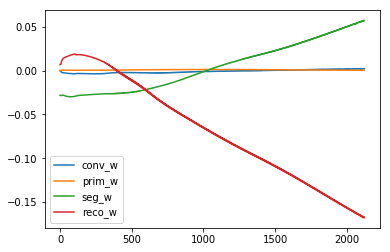

In [9]:
x = range(weights.shape[0])
j=0
for weight in ['conv_w', 'prim_w', 'seg_w', 'reco_w']:
    plt.plot(x, weights[:,j], label=weight)
    j+=1
plt.legend()

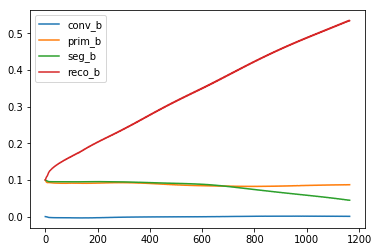

In [128]:
x = range(biases.shape[0])
j=0
for bias in ['conv_b', 'prim_b', 'seg_b', 'reco_b']:
    plt.plot(x, biases[:,j], label=bias)
    j+=1
plt.legend()

In [35]:
sess.run(pipeline.initializer)
m_mag, m_phase, v_mag, v_est_mag, v_mask, v_wave, m_wave = sess.run([model.mixed_mag, 
                                                                     model.mixed_phase, 
                                                                     model.voice_mag,
                                                                     model.gen_voice, 
                                                                     model.voice_mask, 
                                                                     model.voice_audio, 
                                                                     model.mixed_audio],
                                                                    {model.is_training:False})

In [36]:
v_est_wave = list()

for i in range(v_mag.shape[0]):
    v_est_wave.append(af.spectrogramToAudioFile(np.squeeze(v_est_mag[i, :, :, :]).T, n_fft,
                                                fft_hop, phaseIterations=0, phase=np.squeeze(m_phase[i, :, :, :]).T))

In [37]:
ipd.Audio(v_est_wave[1].T, rate=sample_rate)

In [38]:
ipd.Audio(m_wave[1].T, rate=sample_rate)

In [39]:
ipd.Audio(v_wave[1].T, rate=sample_rate)

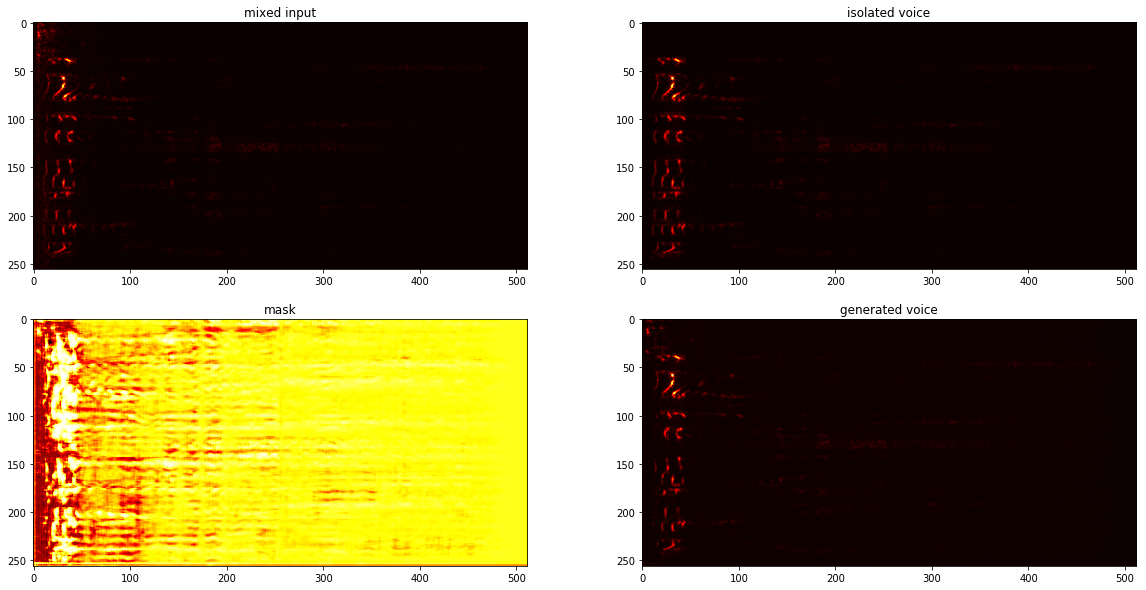

In [40]:
fig, ax = plt.subplots(2,2, figsize=(20,10))

ax[0,0].imshow(m_mag[0,:,:,0])
ax[0,0].set_title('mixed input')
ax[0,1].imshow(v_mag[0,:,:,0])
ax[0,1].set_title('isolated voice')
ax[1,0].imshow(v_mask[0,:,:,0])
ax[1,0].set_title('mask')
ax[1,1].imshow(v_est_mag[0,:,:,0])
ax[1,1].set_title('generated voice')
plt.show()

In [68]:
print(v_mask[0,0,60:70,0])

[ 0.15424208  0.08919515  0.03687616  0.00890494  0.00128618 -0.00061884
         nan  0.00177989  0.00269143  0.00766216]


In [95]:
v_mask.shape

(5, 128, 512, 1)

In [89]:
print(conv_w[:,:,0,0])

[[nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]]


In [42]:
i=4
x = range(len(v_est_wave[i]))
print(len(v_est_wave))
print(len(v_est_wave[0]))

# Estimate the background noise by subtracting the isolated voice and estimated voice from the mixture
bg_ref_mag = m_mag - v_mag
bg_est_mag = m_mag - v_est_mag
bg_ref_wave = []
bg_est_wave = []
for i in range(bg_ref_mag.shape[0]):
    bg_ref_wave.append(af.spectrogramToAudioFile(np.squeeze(bg_ref_mag[i, :, :, :]).T, n_fft,
                                                    fft_hop, phaseIterations=0, phase=np.squeeze(m_phase[i, :, :, :]).T))
    
for i in range(bg_est_mag.shape[0]):
    bg_est_wave.append(af.spectrogramToAudioFile(np.squeeze(bg_est_mag[i, :, :, :]).T, n_fft,
                                                    fft_hop, phaseIterations=0, phase=np.squeeze(m_phase[i, :, :, :]).T))

# Calculate audio metrics for the batch
ref_sources = []
est_sources = []
mixed_sources = []
sdrs = np.empty((0, 2))
sirs = np.empty((0, 2))
sars = np.empty((0, 2))
nsdrs = np.empty((0, 2))
for i in range(batch_size):
    ref_sources.append(np.concatenate((v_wave[i], np.expand_dims(bg_ref_wave[i], axis=1)), axis=1))
    est_sources.append(np.concatenate((np.expand_dims(v_est_wave[i], axis=1), np.expand_dims(bg_est_wave[i], axis=1)), axis=1))
    mixed_sources.append(np.concatenate((m_wave[i], m_wave[i]), axis=1))
    sdr, sir, sar, _ = mir_eval.separation.bss_eval_sources(ref_sources[i].T, est_sources[i].T, compute_permutation=False)
    sdr_mr, _, _, _ = mir_eval.separation.bss_eval_sources(ref_sources[i].T, mixed_sources[i].T, compute_permutation=False)
    nsdr = sdr - sdr_mr
    sdrs = np.concatenate((sdrs, np.expand_dims(sdr, 1).T), axis=0)
    sirs = np.concatenate((sirs, np.expand_dims(sir, 1).T), axis=0)
    sars = np.concatenate((sars, np.expand_dims(sar, 1).T), axis=0)
    nsdrs = np.concatenate((nsdrs, np.expand_dims(nsdr, 1).T), axis=0)

print('Metrics (voice, background):\nSDR\n',
      sdrs, '\nSIR\n', sirs, '\nSAR\n', sars, '\nNSDR\n', nsdrs)

5
65280


/home/enterprise.internal.city.ac.uk/acvn728/.local/lib/python3.5/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


Metrics (voice, background):
SDR
 [[11.164166   -0.35843705]
 [12.95527301 -2.6564285 ]
 [13.82487349  1.79063057]
 [13.87366239 -3.30231096]
 [ 7.14588133  5.33688759]] 
SIR
 [[14.23657736  2.10948104]
 [14.86595196 -1.3606112 ]
 [17.17759758  3.37173325]
 [15.90726836 -2.12494938]
 [ 9.42024491  8.3608466 ]] 
SAR
 [[14.27394884  5.35417863]
 [17.58098992  6.97146027]
 [16.60018059  8.58921201]
 [18.25607405  7.14328583]
 [11.5127413   8.92486034]] 
NSDR
 [[ 2.89264102  6.90199072]
 [ 1.45863707  7.8077943 ]
 [ 4.4804946  10.47773432]
 [ 1.86294951  8.31260472]
 [ 4.32105019  6.96896095]]
